# Lab 05

Student: John Wu

In [1]:
import nltk, sys, gensim, unicodedata
from gensim.models import Word2Vec, KeyedVectors
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

## Analysis of small.txt file

The file contains sentences delimited by line breaks. However, the sentences need to be tokenized first before it can be processed. To do this, we use the [Tok-Tok](https://github.com/jonsafari/tok-tok) tokenizer, which is fast (though simple) tokenizer of sentences that work on different Romance languages.

Since we need to remove puncutations as well, a function is implemented to check if the token is of length 1, and if it is, the [unicode category](https://unicodebook.readthedocs.io/unicode.html#categories) of the token is of punctuation or symbol (or `P` and `S`).

In [2]:
punctCatgs = {'P', 'S'}
def isPunct(tkn): # if length=1 and in unicode punctuation and symbol cateogry
    return len(tkn) == 1 and unicodedata.category(tkn)[0] in punctCatgs

toktok = nltk.toktok.ToktokTokenizer() # instantiate TokTok tokenizer
def tokSentNoPunc(txt): # sentence tokenizer
    return [t for t in toktok.tokenize(txt) if not isPunct(t)]

The file is read in as unicode since there are presence of non-ASCII punctuations and letter. We also convert all text to lower case. The code below reads the file and print out a sample of the tokenized result.

In [3]:
def readFileAndTokenize(filePath):
    with open(filePath, 'r', encoding='utf-8') as f: # open as unicode
        return [tokSentNoPunc(l.casefold()) for l in f] # read lines and tokenize

sents = readFileAndTokenize('./data/small.txt')
print(sents[100:104])

[['eds', 'shareholders', 'to', 'receive', '25.00', 'per', 'share', 'in', 'cash', 'for', 'each', 'eds', 'share'], ['the', 'developer', 'have', 'to', 'present', 'the', 'contract', 'to', 'the', 'bank', 'in', 'order', 'to', 'release', 'the', 'funds'], ['we', 're', 'now', 'examining', 'what', 'role', 'the', 'united', 'nations', 'can', 'play', 'in', 'resolution', 'of', 'this', 'conflict', 'he', 'said.', 'our', 'ambassador', 'to', 'the', 'united', 'nations', 'has', 'begun', 'consultations', 'in', 'this', 'regard'], ['from', 'his', 'remark', 'we', 'can', 'understand', 'that', 'in', 'the', 'private', 'talks', 'in', 'deauville', 'and', 'the', 'discussions', 'before', 'deauville', 'the', 'russians', 'tried', 'to', 'blame', 'romania', 'for', 'the', 'transdniester', 'impasse']]


__Build a word2vec model__

Using the gensim library, a 100-dimension word2vec model is built and word embeddings calculated.

In [4]:
mdl = Word2Vec(sents, size=100, window=5, min_count=2, sg=1, negative=8)

To create a visualization of embedding vectors, we get the first two principal components of several terms.

In [8]:
wrds = ['cat', 'dog', 'truck', 'train', 'two', 'three', 'four', 
        'paris', 'istanbul', 'moscow', 'france', 'turkey', 'russia', ]
v = np.vstack([mdl.wv[s] for s in wrds]).T # stack vectors from all words
pc2 = PCA(n_components=2) # model for PC1 and PC2
pc2.fit(v); # get the PCs

We plot the PC1 on x-axis, PC2 on y-axis, along with text annotation of the data points.

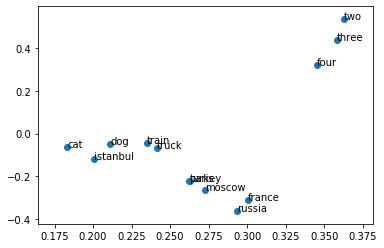

In [9]:
plt.scatter(pc2.components_[0], pc2.components_[1])
for n,w in enumerate(wrds):
    plt.text(pc2.components_[0,n], pc2.components_[1,n], w)
plt.show()

The related words are grouped together generally. For exampe, `two`, `three`, `four` are together on the upper right corner. `train` and `truck` are next to each other, as are `cat` and `dog`. The vector of `russia` - `moscow` is similar to `france` - `paris`

## Google News Pre-trained Embeddings

Below, we read in a pre-trained Google News embeddings file

In [10]:
googFile = './data/GoogleNews-vectors-negative300.bin'
googMdl = KeyedVectors.load_word2vec_format(googFile, binary=True)

### 6.1 Most similar words to several words

In [11]:
googMdl.most_similar('wine')

[('wines', 0.8619791269302368),
 ('chardonnay', 0.7595281004905701),
 ('pinot_noir', 0.7584253549575806),
 ('sparkling_wine', 0.7562699317932129),
 ('sparkling_wines', 0.7555115222930908),
 ('pinot', 0.742101788520813),
 ('rosé', 0.7397210597991943),
 ('vino', 0.7260570526123047),
 ('merlot', 0.7179162502288818),
 ('Pinot_Noir', 0.7176920175552368)]

In [12]:
googMdl.most_similar('fascinating')

[('interesting', 0.762306809425354),
 ('intriguing', 0.7245113849639893),
 ('enlightening', 0.6644250750541687),
 ('captivating', 0.6459898352622986),
 ('facinating', 0.641668438911438),
 ('riveting', 0.6324825286865234),
 ('instructive', 0.6210989356040955),
 ('endlessly_fascinating', 0.6188612580299377),
 ('revelatory', 0.6170244216918945),
 ('engrossing', 0.6126049757003784)]

In [13]:
googMdl.most_similar('cultivate')

[('cultivating', 0.7274794578552246),
 ('cultivated', 0.6766660213470459),
 ('nurture', 0.6695472002029419),
 ('cultivates', 0.6159787178039551),
 ('develop', 0.6053071022033691),
 ('Cultivate', 0.5910323858261108),
 ('Cultivating', 0.5667836666107178),
 ('nuture', 0.5440778732299805),
 ('nourish', 0.5328434109687805),
 ('grow', 0.5282535552978516)]

In general, the result are as expected. Similar terms to "wine" are largely types of wines. Linguistically, one would expect the types of wines to be used in similar context as the generic word wine. 

For the term "fascinating", the most similar terms are all synonyms of the original term. One interesting result is that one of the terms is a typographical error "facinating". However, this also makes sense because one would expect a typo to be used in similar manners as the original term.

For 

### Intuition of Similarity/Distance

In the following section, we explore the similarity scores for a few sets of words.

In [15]:
googMdl.distances('mother', ['father', 'teacher', 'ocean'])

array([0.20985174, 0.6231039 , 0.8943766 ], dtype=float32)

In [26]:
googMdl.distances('Vietnam', ['Thailand', 'China', 'Egypt', 'Spain'])

array([0.49617392, 0.44819546, 0.7123459 , 0.78796744], dtype=float32)

In [29]:
googMdl.distances('beef', ['pork', 'rice', 'water'])

array([0.33986348, 0.5947554 , 0.91249037], dtype=float32)

The results for these three sets of words are as expected. "Mother" should be used in a more similar context as "father" vs. "teacher" or largely unrelated "ocean". When comparing Vietnam to other country names, it is closest to Thailand, followed by China, Egypt and then Spain. In this case, the similarity follows geographical (and also cultural) distribution of the countries. For the word "beef", it's more similar to "pork" than "rice" and "water". As one would expect pork to be used in the same manner as beef, since they are both meat and possible substitute. On the other hand, "beef" sometimes can be with "rice" to describe a meal. 

### Analogies

With `most_similar_cosmul` function, we could complete analogies in the form of x:y::a:b. For example, puppies:dog::cat:kittens

In [30]:
googMdl.most_similar_cosmul(['puppies', 'cat'], ['dog'], 1)

[('kittens', 0.9692491292953491)]

The following are some more examples of analogies

In [17]:
googMdl.most_similar_cosmul(['read', 'music'], ['book'], 1)

[('listen', 0.915989875793457)]

In [18]:
googMdl.most_similar_cosmul(['hot', 'winter'], ['summer'], 1)

[('cold', 0.8846044540405273)]

In [23]:
print(googMdl.distances('small', ['tiny', 'large', 'ice']))
print(np.linalg.norm(googMdl['large'] - googMdl['small']))
print(np.linalg.norm(googMdl['tiny'] - googMdl['small']))

[0.28120732 0.26688498 0.88406587]
1.5743394
1.7342917


In [ ]:
del googMdl

## Word Embedding for Translations

Read in text files for both languages and tokenize them using Tok-Tok. 

In [ ]:
engSents = readFileAndTokenize('./data/eng.txt')
spaSents = readFileAndTokenize('./data/spa.txt')

Training models and saving results

In [ ]:
engModel = Word2Vec(engSents, size=100, window=5, min_count=2, sg=1, negative=8)
spaModel = Word2Vec(spaSents, size=100, window=5, min_count=2, sg=1, negative=8)

In [ ]:
engModel.wv.save_word2vec_format('eng.w2v.model')
spaModel.wv.save_word2vec_format('spa.w2v.model')

Run vecmap code to learn bilingual projections

In [ ]:
%run ./vecmap/map_embeddings.py --supervised data/es-en.train.txt \ 
    spa.w2v.model eng.w2v.model spa_mapped.emb eng_mapped.emb 

Load the bilingual embeddings

In [ ]:
spa2eng = gensim.models.KeyedVectors.load_word2vec_format('spa_mapped.emb')
eng2spa = gensim.models.KeyedVectors.load_word2vec_format('eng_mapped.emb') 

Test out the various translations by displaying the corresponding word.

In [31]:
def printTranslation(words, engInput=False):
    if isinstance(words, str):
        words = [words]
    for w in words:
        if engInput:
            trans = eng2spa.similar_by_vector(spa2eng[w])[0]
            print("Sp: %s = En: %s, (%f)" % (w, trans[0], trans[1]))
        else:
            trans = spa2eng.similar_by_vector(eng2spa[w])[0]
            print("En: %s = Sp: %s, (%f)" % (w, trans[0], trans[1]))

In [ ]:
l = ['playa', 'villa', 'perros', 'naufragio', 'islas', 'cantar', 
     'calles', 'naranjas', 'bomberos', 'escalera', 'nadó','frontera',
     'pasaporte', 'fábrica']
printTranslation(l)

In [ ]:
l2 = ['jugar', 'juego', 'juegas', 'juega', 'jugamos', 'juegan']
printTranslation(l2)

In [ ]:
l3 = ['europeo', 'español', 'cubano', 'ecuatoriano', 'francés', 'alemán', 
      'chino', 'japonés', 'americano', 'estadounidense',  'egipcio',
      'turco', 'nigeriano']
printTranslation(l3)